# 어떤 광고가 반응이 더 좋은가?
#### 게임 개발회사 A는 지난 문제를 현명하게 해결하고 안정적인 영업을 하고 있으나, 매월 실시하고 있는 게임아이템 판매 이벤트에 대해 고객들의 구매율이 상대적으로 낮음을 확인하였음.
#### 우리 회사는 맨날 무슨 일이 터지나?
![](2-1.jpg)

#### 유력 가설: 이벤트 공지 및 홍보 활동에 문제가 있다. 구체적으로 우리 게임에 대한 광고 클릭률이 항상 낮다고 한다.
#### 해결책: 다양한 광고를 조사하고 비교해서 우리 게임 광고 클릭

## 1. Loading data

#### 1) 필요한 라이브러리들을 호출

In [1]:
#데이터 분석에 필요한 패키지들을 파이썬으로 호출
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
%matplotlib inline

#### 2) 각 변수별로 데이터 할당 

In [6]:
imp = pd.read_csv("ab_test_imp.csv", sep=',')
goal = pd.read_csv("ab_test_goal.csv", sep=',')

![](2-2.jpg)

#### 3) 호출된 데이터 정보 확인

In [7]:
imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2017-10-01,game-01,sales_test,B,36703,25622
1,2017-10-01,game-01,sales_test,A,44339,25623
2,2017-10-01,game-01,sales_test,B,32087,25624
3,2017-10-01,game-01,sales_test,B,10160,25625
4,2017-10-01,game-01,sales_test,B,46113,25626


In [8]:
goal.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2017-10-01,game-01,sales_test,B,15021,25638
1,2017-10-01,game-01,sales_test,B,351,25704
2,2017-10-01,game-01,sales_test,B,8276,25739
3,2017-10-01,game-01,sales_test,B,1230,25742
4,2017-10-01,game-01,sales_test,B,17471,25743


# 2. Data cleaning

#### 1) 각 데이터들을 결합

In [10]:
#두 데이터 결합하기 
ImpGoal = imp.merge(goal, on=["transaction_id"], how="outer")
ImpGoal.head(20)

,log_date_x,app_name_x,test_name_x,test_case_x,user_id_x,transaction_id,log_date_y,app_name_y,test_name_y,test_case_y,user_id_y
0,2017-10-01,game-01,sales_test,B,36703.0,25622,NaN,NaN,NaN,NaN,NaN
1,2017-10-01,game-01,sales_test,A,44339.0,25623,NaN,NaN,NaN,NaN,NaN
2,2017-10-01,game-01,sales_test,B,32087.0,25624,NaN,NaN,NaN,NaN,NaN
3,2017-10-01,game-01,sales_test,B,10160.0,25625,NaN,NaN,NaN,NaN,NaN
4,2017-10-01,game-01,sales_test,B,46113.0,25626,NaN,NaN,NaN,NaN,NaN
5,2017-10-01,game-01,sales_test,A,6605.0,25627,NaN,NaN,NaN,NaN,NaN
6,2017-10-01,game-01,sales_test,A,346.0,25628,NaN,NaN,NaN,NaN,NaN
7,2017-10-01,game-01,sales_test,A,42710.0,25629,NaN,NaN,NaN,NaN,NaN
8,2017-10-01,game-01,sales_test,A,37194.0,25630,NaN,NaN,NaN,NaN,NaN
9,2017-10-01,game-01,sales_test,A,123.0,25631,NaN,NaN,NaN,NaN,NaN


#### 2) 일자별 정렬을 위한 날짜 처리

In [12]:
# ImpGoal 데이터프레임 내 "log_date_x"시리즈를 datetime 유형으로 변경
ImpGoal['log_date_x'] = ImpGoal['log_date_x'].apply(lambda x: pd.to_datetime(str(x)))

#### 3) 광고별 클릭률 지표 설정

In [15]:
#"is.goal" 시리즈를 만들고 "user_id_y"값이 "true"이면 0, 그렇지 않으면 1으로 표시
ImpGoal['is_goal'] = np.where(pd.isnull(ImpGoal["user_id_y"]) == True, 0, 1)

In [16]:
ImpGoal.head(3)

,log_date_x,app_name_x,test_name_x,test_case_x,user_id_x,transaction_id,log_date_y,app_name_y,test_name_y,test_case_y,user_id_y,is_goal
0,2017-10-01,game-01,sales_test,B,36703.0,25622,NaN,NaN,NaN,NaN,NaN,0
1,2017-10-01,game-01,sales_test,A,44339.0,25623,NaN,NaN,NaN,NaN,NaN,0
2,2017-10-01,game-01,sales_test,B,32087.0,25624,NaN,NaN,NaN,NaN,NaN,0


# 3. Data analysis

#### 1) 광고별 클릭률 확인

In [17]:
# 광고A와 광고B의 각 클릭률 비교
ImpGoal['is_goal'].groupby(ImpGoal['test_case_x']).mean()

test_case_x
A    0.080256
B    0.115392
Name: is_goal, dtype: float64

#### 2) 각 광고별 클릭률 트렌드 확인

In [23]:
#"log_date_x" 기준에 따라 각 광고별 클릭률을 정렬
data = ImpGoal.groupby(["log_date_x", "test_case_x"])['is_goal'].mean()
data

log_date_x  test_case_x
2017-10-01  A              0.072165
            B              0.126528
2017-10-02  A              0.064234
            B              0.159040
2017-10-03  A              0.140148
            B              0.150041
2017-10-04  A              0.058514
            B              0.119015
2017-10-05  A              0.035287
            B              0.065637
2017-10-06  A              0.098441
            B              0.126023
2017-10-07  A              0.121630
            B              0.113427
2017-10-08  A              0.070664
            B              0.121010
2017-10-09  A              0.120752
            B              0.093365
2017-10-10  A              0.083578
            B              0.072165
2017-10-11  A              0.044737
            B              0.062419
2017-10-12  A              0.038102
            B              0.105190
2017-10-13  A              0.098039
            B              0.147863
2017-10-14  A              0.051310
    

# 4. Data Visualization

#### 1) 각 광고별 클릭률 트렌드 시각화

In [24]:
# unstack()함수를 이용해 완전한 데이터 정규화 수행
data = data.unstack('test_case_x')

In [25]:
data.head()

test_case_x,A,B
log_date_x,,
2017-10-01,0.072165,0.126528
2017-10-02,0.064234,0.159040
2017-10-03,0.140148,0.150041
2017-10-04,0.058514,0.119015
2017-10-05,0.035287,0.065637


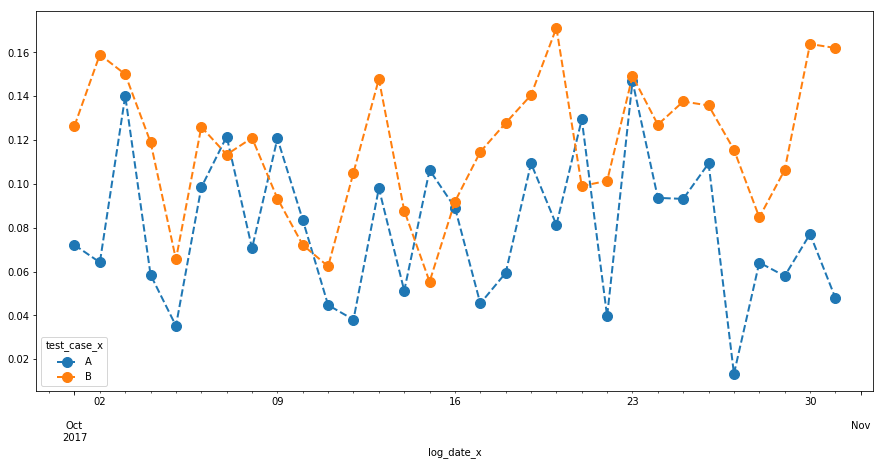

In [26]:
#완성된 데이터를 이용해 시각화 수행
data.plot.line(figsize=(15,7), style='--', marker='o', markersize=10, linewidth=2)